In [26]:
import json
import pandas as pd

### Dataclasses based on the documentation (Some of the documentation is outdated, so this is not guaranteed to be right)

In [1]:
from dataclasses import dataclass
from typing import Literal, List
from enum import Enum

class Side(str, Enum):
    BUY = "BUY"
    SELL = "SELL"

@dataclass
class OrderSummary:
    size: str  # or float if you want to convert from string
    price: str  # or float if you want to convert from string

@dataclass
class BookMessage:
    asset_id: str
    market: str
    timestamp: str
    hash: str
    bids: List[OrderSummary]
    asks: List[OrderSummary]
    event_type: str = "book"

@dataclass
class PriceChange:
    asset_id: str
    price: str  # can convert to float if needed
    size: str   # can convert to float if needed
    side: Side
    hash: str
    best_bid: str
    best_ask: str

@dataclass
class PriceChangeEvent:
    market: str
    price_changes: List[PriceChange]
    timestamp: str
    event_type: str = "price_change"

@dataclass
class TickSizeChangeEvent:
    asset_id: str
    market: str # condition_id
    old_tick_size: str
    new_tick_size: str
    timestamp: str
    event_type: str = "tick_size_change"

@dataclass
class LastTradePriceEvent:
    asset_id: str
    fee_rate_bps: str
    market: str # condition_id
    price: str
    side: Side
    size: str
    timestamp: str
    event_type = "last_trade_price"

### Parsing Data From the Market Stream

In [18]:
with open ("../btc_8_815_updown.json") as f:
    data = json.load(f)

In [14]:
EVENT_TYPES = {
    "last_trade_price": LastTradePriceEvent,
    "tick_size_change": TickSizeChangeEvent,
    "price_change": PriceChangeEvent,
    "book": BookMessage
}

In [19]:
def parse_book(book_message):
    condition_id = book_message['market']
    asset_id = book_message['asset_id']
    timestamp = book_message['timestamp']
    hash = book_message['hash'] # hash summary of orderbook content
    bids = book_message['bids']
    asks = book_message['asks']

    # use this to generate updates
    order_book_updates = []
    for bid in bids:
        update = {
            "asset_id": asset_id,
            "timestamp": timestamp,
            "price": bid['price'],
            "size": bid['size'],
            "side": "bid",
        }
        order_book_updates.append(update)
    for ask in asks:
        update = {
            "asset_id": asset_id,
            "timestamp": timestamp,
            "price": ask['price'],
            "size": ask['size'],
            "side": "ask",
        }
        order_book_updates.append(update)

    return order_book_updates

In [20]:
def parse_price_change(price_change_event):
    condition_id = price_change_event['market']
    price_changes = price_change_event['price_changes']
    timestamp = price_change_event['timestamp']
    order_book_updates = []
    
    for price_change in price_changes:
        # NOTE, also has best bid and best ask data, but idrc
        update = {
                "asset_id": price_change['asset_id'],
                "timestamp": timestamp,
                "price": price_change['price'],
                "size": price_change['size'],
                "side": "bid" if 'side' == "BUY" else "ask"
            }
        order_book_updates.append(update)

    return order_book_updates

In [21]:
data[1]

{'market': '0x56f8de8878e825b73937be862fdcd7af2497c5b73df1dac0fd9113bf11846176',
 'price_changes': [{'asset_id': '101160920341113437254721927007904783071619510617577160798815803852851616980409',
   'price': '0.47',
   'size': '22',
   'side': 'BUY',
   'hash': 'eaa7eb8f4c2bfbb1575968ec19157561c98efbfa',
   'best_bid': '0.47',
   'best_ask': '0.5'},
  {'asset_id': '105565563395033883985404616266276261920203530949669912238075249022113023944893',
   'price': '0.53',
   'size': '22',
   'side': 'SELL',
   'hash': 'e2160dd739e0a9891e31f5c2335f6c1196b82872',
   'best_bid': '0.5',
   'best_ask': '0.53'}],
 'timestamp': '1761652917077',
 'event_type': 'price_change'}

In [ ]:
def handle_event():
    pass

In [36]:
message

{'market': '0x56f8de8878e825b73937be862fdcd7af2497c5b73df1dac0fd9113bf11846176',
 'price_changes': [{'asset_id': '101160920341113437254721927007904783071619510617577160798815803852851616980409',
   'price': '0.2',
   'size': '0',
   'side': 'BUY',
   'hash': 'd87cb0b4e602ddbfc0bee64082bcafdd20e87151',
   'best_bid': '0',
   'best_ask': '1'},
  {'asset_id': '105565563395033883985404616266276261920203530949669912238075249022113023944893',
   'price': '0.8',
   'size': '0',
   'side': 'SELL',
   'hash': '2403e70846d15c8412afabef115a5548cedf5d89',
   'best_bid': '0',
   'best_ask': '1'}],
 'timestamp': '1761653765562',
 'event_type': 'price_change'}

In [3]:
trade_event[0]

NameError: name 'trade_event' is not defined

In [23]:
trade_event = []
order_book_data = []
for message in data:
    order_book_updates = []
    if isinstance(message, list):
        for event in message:
            event_type = event['event_type']
            if event_type == "book":
                order_book_updates = parse_book(event)
            elif event_type == "price_change":
                order_book_updates = parse_price_change(event)
            elif event_type == "tick_size_change":
                pass # old tick size vs new tick size
            elif event_type == "last_trade_price":
                pass
                trade_event.append(event)
            else:
                pass

            order_book_data += order_book_updates
            order_book_updates.clear()

    elif isinstance(message, dict):
        event = message
        event_type = event['event_type']
        if event_type == "book":
            order_book_updates = parse_book(event)
        elif event_type == "price_change":
            order_book_updates = parse_price_change(event)
        elif event_type == "tick_size_change":
            pass # old tick size vs new tick size
            print("TICK")
        elif event_type == "last_trade_price":
            trade_event.append(event)
            # print("TRADE")
        else:
            pass
        order_book_data += order_book_updates
        order_book_updates.clear()
    else:
        pass

    

            
                


In [49]:
book_update_df = pd.DataFrame(order_book_data).sort_values(by="timestamp")

In [33]:
import numpy as np
tick_size = 0.01
np.linspace(0, 1, int(1/tick_size)+1)

In [50]:
from sortedcontainers import SortedDict
def reconstruct_order_book(data:pd.DataFrame, asset_id, timestamp):
    order_book = {}
    # order_book['bid'] = {{"price": x, "size": 0} for x in np.linspace(0, 1, int(1/tick_size)+1)}
    # order_book['ask'] = {{"price": x, "size": 0} for x in np.linspace(0, 1, int(1/tick_size)+1)}
    order_book['bid'] = SortedDict()
    order_book['ask'] = SortedDict()
    updates = data[data['asset_id']==asset_id]
    updates = updates.sort_values(by="timestamp")

    for _, row in  updates[updates['timestamp'] <= timestamp].iterrows():
        if row.size == 0:
            order_book[row.side].pop(row.price, None)
        else:
            order_book[row.side][row.price] = row.size
    
    return order_book



In [52]:
reconstruct_order_book(book_update_df, asset_id='101160920341113437254721927007904783071619510617577160798815803852851616980409', timestamp='1761653295004')

{'bid': SortedDict({'0.01': 5, '0.02': 5, '0.03': 5, '0.04': 5, '0.05': 5, '0.06': 5, '0.07': 5, '0.08': 5, '0.09': 5, '0.1': 5, '0.11': 5, '0.12': 5, '0.13': 5, '0.14': 5, '0.15': 5, '0.16': 5, '0.17': 5, '0.18': 5, '0.19': 5, '0.2': 5, '0.21': 5, '0.22': 5, '0.23': 5, '0.24': 5, '0.25': 5, '0.26': 5, '0.27': 5, '0.28': 5, '0.29': 5, '0.3': 5, '0.31': 5, '0.32': 5, '0.33': 5, '0.34': 5, '0.35': 5, '0.36': 5, '0.37': 5, '0.38': 5, '0.39': 5, '0.4': 5, '0.41': 5, '0.42': 5, '0.43': 5, '0.44': 5, '0.45': 5, '0.46': 5, '0.47': 5, '0.48': 5, '0.49': 5, '0.5': 5, '0.51': 5, '0.52': 5, '0.53': 5, '0.54': 5, '0.55': 5, '0.56': 5, '0.57': 5, '0.58': 5, '0.59': 5, '0.6': 5, '0.61': 5, '0.62': 5, '0.63': 5, '0.64': 5, '0.65': 5, '0.66': 5, '0.67': 5, '0.68': 5, '0.69': 5, '0.7': 5, '0.71': 5, '0.72': 5, '0.73': 5, '0.74': 5, '0.75': 5, '0.76': 5, '0.77': 5}),
 'ask': SortedDict({'0.01': 5, '0.02': 5, '0.03': 5, '0.04': 5, '0.05': 5, '0.06': 5, '0.07': 5, '0.08': 5, '0.09': 5, '0.1': 5, '0.11': 5

In [59]:
trade_event[230]

{'market': '0x56f8de8878e825b73937be862fdcd7af2497c5b73df1dac0fd9113bf11846176',
 'asset_id': '101160920341113437254721927007904783071619510617577160798815803852851616980409',
 'price': '0.79',
 'size': '30',
 'fee_rate_bps': '0',
 'side': 'BUY',
 'timestamp': '1761653294004',
 'event_type': 'last_trade_price',
 'transaction_hash': '0x9f98780854ec4ca54849181cf4c4bed380a337dde52372b10c0ef2888ae4a9f0'}

### Getting Trade data from trade endpoint

In [8]:
import requests
url = "https://data-api.polymarket.com/trades"
params = {
    "limit": 500,
    "offset": 0,
    # "market": ['0x56f8de8878e825b73937be862fdcd7af2497c5b73df1dac0fd9113bf11846176'],
    "market": ["0x6f5a9ac3e56348995af1f871fda6e5b301375859b3062b97aa968816aceed60f"]
    # "takerOnly": "true",
}
response = requests.get(url, params=params)
trades = []
while len(response.json()):
    trades += response.json()
    params['offset'] += 500
    response = requests.get(url, params=params)

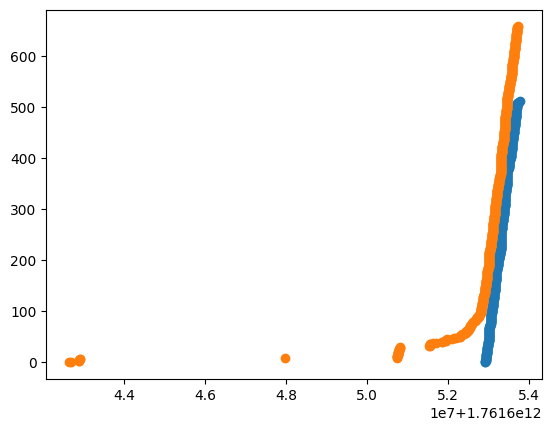

In [73]:
import matplotlib.pyplot as plt
plt.scatter([int(e['timestamp']) for e in trade_event], range(len(trade_event)))
plt.scatter([int(e['timestamp'])*1000 for e in trades[::-1]], range(len(trades)))

In [15]:
from collections import defaultdict
counts = defaultdict(int)
for trade in trades:
    counts[trade['outcome']] += 1
counts

defaultdict(int, {'Up': 310, 'Down': 147})

In [12]:
outcome.add("hi")

In [10]:
trade

{'proxyWallet': '0xfcd2fde8e69005fb6ef78537a2646ad030b26535',
 'side': 'BUY',
 'asset': '98609621745459687469557651541160413948833598590564588692597826915978981517946',
 'conditionId': '0x6f5a9ac3e56348995af1f871fda6e5b301375859b3062b97aa968816aceed60f',
 'size': 5.99,
 'price': 0.999,
 'timestamp': 1761689105,
 'title': 'Ethereum Up or Down - October 28, 3:30PM-3:45PM ET',
 'slug': 'eth-updown-15m-1761679800',
 'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/ETH+fullsize.jpg',
 'eventSlug': 'eth-updown-15m-1761679800',
 'outcome': 'Up',
 'outcomeIndex': 0,
 'name': 'un3xp3C73d1Y64d200k5',
 'pseudonym': 'Zigzag-Breakpoint',
 'bio': '',
 'profileImage': '',
 'profileImageOptimized': '',
 'transactionHash': '0xc9ac48c251344f7cacd6141063f2f6b48ee7c4285c3e15a8015b0ca6d3e1a8ff'}

In [86]:
len(trades)

457

In [82]:
response.json()

[{'proxyWallet': '0x47a35c8fdcdce37d9e19241d34e295fcb4911bce',
  'side': 'SELL',
  'asset': '101160920341113437254721927007904783071619510617577160798815803852851616980409',
  'conditionId': '0x56f8de8878e825b73937be862fdcd7af2497c5b73df1dac0fd9113bf11846176',
  'size': 1.06,
  'price': 0.99,
  'timestamp': 1761653725,
  'title': 'Bitcoin Up or Down - October 28, 8:00AM-8:15AM ET',
  'slug': 'btc-updown-15m-1761652800',
  'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/BTC+fullsize.png',
  'eventSlug': 'btc-updown-15m-1761652800',
  'outcome': 'Down',
  'outcomeIndex': 1,
  'name': 'kkk829',
  'pseudonym': 'Excited-Choosing',
  'bio': '',
  'profileImage': '',
  'profileImageOptimized': '',
  'transactionHash': '0xb7b6e6d54711e0e0ec88596ac3398f496a19e7118a597fe9b85d95140b9e5906'},
 {'proxyWallet': '0xd13321a9af3ecb5fa33f9a36fc368c783c81d55f',
  'side': 'SELL',
  'asset': '101160920341113437254721927007904783071619510617577160798815803852851616980409',
  'conditionId': '0x

In [60]:
# NOTE NEED AN AUTHENTICATED USER
# url = "https://clob.polymarket.com/data/trades"
# params = {
#     "market": ['0x56f8de8878e825b73937be862fdcd7af2497c5b73df1dac0fd9113bf11846176'],
# }
# response = requests.get(url, params=params)

In [61]:
response.json()

{'error': 'Unauthorized/Invalid api key'}

In [74]:
len(trades)

659

In [58]:
trades[60]

{'proxyWallet': '0xca85f4b9e472b542e1df039594eeaebb6d466bf2',
 'side': 'SELL',
 'asset': '101160920341113437254721927007904783071619510617577160798815803852851616980409',
 'conditionId': '0x56f8de8878e825b73937be862fdcd7af2497c5b73df1dac0fd9113bf11846176',
 'size': 50,
 'price': 0.89,
 'timestamp': 1761653611,
 'title': 'Bitcoin Up or Down - October 28, 8:00AM-8:15AM ET',
 'slug': 'btc-updown-15m-1761652800',
 'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/BTC+fullsize.png',
 'eventSlug': 'btc-updown-15m-1761652800',
 'outcome': 'Down',
 'outcomeIndex': 1,
 'name': 'aespakarina',
 'pseudonym': 'Idle-Exaggeration',
 'bio': 'im like some kind of supernova',
 'profileImage': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/profile-image-903202-8b12b8b3-d90d-4357-98bc-2816f761a91e.jpg',
 'profileImageOptimized': '',
 'transactionHash': '0x31360363295facbcad46ebc25308fea7bb41fbfa7f2bde681d123d71336936b4'}

In [41]:
len(trades)

659

In [39]:
len(response.json())

500

In [35]:
# KEEP GOING FOR TESTING AS TO WHAT HAPPENS WHEN A MARKET DIES FROM THE OTHER NOTEBOOK
import datetime as dt
import websockets
url = 'wss://ws-subscriptions-clob.polymarket.com/ws/market'
last_time_pong = dt.datetime.now()
asset_ids = ["111982930202787843078370123399827216485506399038350852586731005165614131335546"]
msgs = []
async with websockets.connect(url) as websocket:
    await websocket.send(json.dumps({"assets_ids":asset_ids,"type":"market"}))

    while len(msgs) < 20:
        m = await websocket.recv()
        if m != "PONG":
            last_time_pong = dt.datetime.now()
        try:
            d = json.loads(m)
            msgs.append(d)
            # print(d)
            print(len(msgs))
        except json.JSONDecodeError:
            print("Received non-JSON message:", m)
            continue
        
        if last_time_pong + dt.timedelta(seconds=10) < dt.datetime.now():
            await websocket.send("PING")

1


CancelledError: 

In [20]:
condition_id = event['market']
asset_id = event['asset_id']
timestamp = event['timestamp']
hash = event['hash'] # hash summary of orderbook content
bids = event['bids']
asks = event['asks']

# use this to generate updates
order_book_updates = []
for bid in bids:
    update = {
        "asset_id": asset_id,
        "timestamp": timestamp,
        "price": bid['price'],
        "size": bid['size'],
        "side": "bid",
    }
    order_book_updates.append(update)
for ask in asks:
    update = {
        "asset_id": asset_id,
        "timestamp": timestamp,
        "price": ask['price'],
        "size": ask['size'],
        "side": "ask",
    }
    order_book_updates.append(update)

# TODO -> will need to normalize so that each order doesn't have this massive asset id to contend with

In [21]:
order_book_updates

[{'asset_id': '105565563395033883985404616266276261920203530949669912238075249022113023944893',
  'timestamp': '1761652917071',
  'price': '0.01',
  'size': '83039',
  'side': 'bid'},
 {'asset_id': '105565563395033883985404616266276261920203530949669912238075249022113023944893',
  'timestamp': '1761652917071',
  'price': '0.02',
  'size': '2366',
  'side': 'bid'},
 {'asset_id': '105565563395033883985404616266276261920203530949669912238075249022113023944893',
  'timestamp': '1761652917071',
  'price': '0.03',
  'size': '1488',
  'side': 'bid'},
 {'asset_id': '105565563395033883985404616266276261920203530949669912238075249022113023944893',
  'timestamp': '1761652917071',
  'price': '0.04',
  'size': '1245',
  'side': 'bid'},
 {'asset_id': '105565563395033883985404616266276261920203530949669912238075249022113023944893',
  'timestamp': '1761652917071',
  'price': '0.05',
  'size': '370',
  'side': 'bid'},
 {'asset_id': '1055655633950338839854046162662762619202035309496699122380752490221130

In [19]:
data[1]

{'market': '0x56f8de8878e825b73937be862fdcd7af2497c5b73df1dac0fd9113bf11846176',
 'price_changes': [{'asset_id': '101160920341113437254721927007904783071619510617577160798815803852851616980409',
   'price': '0.47',
   'size': '22',
   'side': 'BUY',
   'hash': 'eaa7eb8f4c2bfbb1575968ec19157561c98efbfa',
   'best_bid': '0.47',
   'best_ask': '0.5'},
  {'asset_id': '105565563395033883985404616266276261920203530949669912238075249022113023944893',
   'price': '0.53',
   'size': '22',
   'side': 'SELL',
   'hash': 'e2160dd739e0a9891e31f5c2335f6c1196b82872',
   'best_bid': '0.5',
   'best_ask': '0.53'}],
 'timestamp': '1761652917077',
 'event_type': 'price_change'}

In [11]:
data[0]

[{'market': '0x56f8de8878e825b73937be862fdcd7af2497c5b73df1dac0fd9113bf11846176',
  'asset_id': '105565563395033883985404616266276261920203530949669912238075249022113023944893',
  'timestamp': '1761652917071',
  'hash': 'fe7b74f4a47dcd77d7cd243198a72d130365a49a',
  'bids': [{'price': '0.01', 'size': '83039'},
   {'price': '0.02', 'size': '2366'},
   {'price': '0.03', 'size': '1488'},
   {'price': '0.04', 'size': '1245'},
   {'price': '0.05', 'size': '370'},
   {'price': '0.06', 'size': '173'},
   {'price': '0.07', 'size': '155'},
   {'price': '0.08', 'size': '127'},
   {'price': '0.09', 'size': '138'},
   {'price': '0.1', 'size': '360'},
   {'price': '0.11', 'size': '90'},
   {'price': '0.12', 'size': '70'},
   {'price': '0.13', 'size': '56'},
   {'price': '0.14', 'size': '56'},
   {'price': '0.15', 'size': '122'},
   {'price': '0.2', 'size': '65'},
   {'price': '0.28', 'size': '32'},
   {'price': '0.3', 'size': '80'},
   {'price': '0.33', 'size': '14'},
   {'price': '0.34', 'size': '2